# Fake Review Detection using LSTM - Improved Version

## Improvements Made:
1. **Class Weights** - Handles imbalanced dataset
2. **Bidirectional LSTM** - Reads text both forward and backward
3. **Extended Training** - 15 epochs with early stopping
4. **Learning Rate Scheduling** - Adapts learning rate automatically
5. **Better Metrics** - Tracks accuracy, precision, and recall

These improvements should increase accuracy from ~54% to 65-75%

## Step 1: Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Step 2: Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os

# Machine Learning imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_class_weight  # NEW: For handling imbalance

# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, BatchNormalization  # NEW: Bidirectional, BatchNormalization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau  # NEW: ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print("All libraries imported successfully!")

TensorFlow version: 2.19.0
All libraries imported successfully!


## Step 3: Load Data

In [ ]:
# Load training and test data
train_df = pd.read_csv('new_data_train.csv', sep='\t', on_bad_lines='skip')
test_df  = pd.read_csv('new_data_test.csv', sep='\t', on_bad_lines='skip')


print(f"Training data: {train_df.shape[0]} samples")
print(f"Test data: {test_df.shape[0]} samples")
print("\nFirst few rows:")
train_df.head()

Training data: 9929 samples
Test data: 2483 samples

First few rows:


,Unnamed: 0,reviewID,reviewerID,restaurantID,date,rating,reviewUsefulCount,reviewContent,flagged,name,...,reviewCount,firstCount,usefulCount,coolCount,funnyCount,complimentCount,tipCount,fanCount,restaurantRating,ReviewLength
0,6010,Z_wgGcI8_Txo87Wz7CxdrQ,cM9GIlk61Qh2thLyJyxNyA,N7juvW8YoFIj7sEBzVF8GQ,9/17/2010,5,0,as new resident chicago los angeles i mission ...,1,suzie n.,...,1,0,1,2,0,0,0,0,4.0,144
1,6566,NJfQb03MSstqYagt860Oaw,SVlSPBnjCzY2Bu9n8y2C5A,o54U2VkQama8FI30qDkWvw,1/31/2008,5,0,great place rarely wait fairly easy find parki...,0,Jacqui B.,...,12,2,19,7,6,4,0,0,4.0,46
2,21349,2uao3bK9iSV4fuMwuSYCiQ,5HYWhPS3ozYifieW0lWMUw,1QKqtC4vML3QhkrSzwR_tQ,3/31/2010,5,0,back bar makes feel though transported china s...,1,Mike A.,...,6,0,7,3,2,0,0,0,3.5,18
3,10370,6mVU2JfeSbQ-5RnPm-K6eA,dgKmhiTypR34XNPrMtQyMA,4wreIFjaPMppyEnzKHbozg,4/26/2010,5,0,hands one favorite tourist restaurants city th...,0,Jen K.,...,37,2,16,3,3,1,0,1,3.5,41
4,6011,e25NUAMnVf7-t8-vBO_drA,uB3n74XHDFUKwHxfK5lDvA,N7juvW8YoFIj7sEBzVF8GQ,9/7/2010,5,0,service impeccable staff helpful owner works h...,1,Joe K.,...,3,0,2,1,0,0,0,0,4.0,40


In [ ]:
# Check class distribution
print("Class Distribution in Training Data:")
print(train_df['flagged'].value_counts())
print("\nPercentages:")
print(train_df['flagged'].value_counts(normalize=True) * 100)

Class Distribution in Training Data:
flagged
0    4994
1    4935
Name: count, dtype: int64

Percentages:
flagged
0    50.297109
1    49.702891
Name: proportion, dtype: float64


## Step 4: Text Preprocessing

In [ ]:
def clean_text(text):
    """Clean and preprocess text"""
    if pd.isna(text):
        return ""
    text = str(text).lower()  # Convert to lowercase
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

# Clean the reviews
print("Cleaning text...")
train_df['cleaned_review'] = train_df['reviewContent'].apply(clean_text)
test_df['cleaned_review'] = test_df['reviewContent'].apply(clean_text)

# Remove empty reviews
train_df = train_df[train_df['cleaned_review'] != '']
test_df = test_df[test_df['cleaned_review'] != '']

print(f"After cleaning: {len(train_df)} training samples, {len(test_df)} test samples")

Cleaning text...
After cleaning: 9926 training samples, 2483 test samples


## Step 5: Prepare Data

In [ ]:
# Separate features (X) and labels (y)
X_train = train_df['cleaned_review'].values
y_train = train_df['flagged'].values

X_test = test_df['cleaned_review'].values
y_test = test_df['flagged'].values

print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

X_train: (9926,)
y_train: (9926,)
X_test: (2483,)
y_test: (2483,)


## Step 6: Tokenization and Padding

In [ ]:
# Settings
MAX_WORDS = 10000  # Maximum vocabulary size
MAX_SEQUENCE_LENGTH = 200  # Maximum review length

# Create and fit tokenizer
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

# Convert text to sequences of numbers
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

# Pad sequences to same length
X_train_padded = pad_sequences(X_train_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

print(f"Vocabulary size: {len(tokenizer.word_index) + 1}")
print(f"X_train_padded shape: {X_train_padded.shape}")
print(f"X_test_padded shape: {X_test_padded.shape}")

Vocabulary size: 24469
X_train_padded shape: (9926, 200)
X_test_padded shape: (2483, 200)


In [ ]:
# Create validation split (80% train, 20% validation)
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_padded, y_train,
    test_size=0.2,
    random_state=42,
    stratify=y_train
)

print(f"Training: {len(X_train_final)} samples")
print(f"Validation: {len(X_val)} samples")
print(f"Test: {len(X_test_padded)} samples")

Training: 7940 samples
Validation: 1986 samples
Test: 2483 samples


## Step 7: Calculate Class Weights (NEW - Handles Imbalance)

**Why?** Your dataset has more real reviews than fake reviews. Class weights tell the model to pay more attention to the minority class (fake reviews), fixing the low precision problem.

In [ ]:
# Calculate class weights
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_final),
    y=y_train_final
)

class_weight_dict = {
    0: class_weights_array[0],  # Real reviews
    1: class_weights_array[1]   # Fake reviews
}

print("Class Weights:")
print(f"  Real reviews (0): {class_weight_dict[0]:.4f}")
print(f"  Fake reviews (1): {class_weight_dict[1]:.4f}")
print("\n→ The model will now pay more attention to fake reviews during training")

Class Weights:
  Real reviews (0): 0.9940
  Fake reviews (1): 1.0061

→ The model will now pay more attention to fake reviews during training


## Step 8: Build Improved LSTM Model

**Key Improvements:**
1. **Bidirectional LSTM** - Reads text forward and backward for better context
2. **Two LSTM layers** - Captures more complex patterns
3. **Batch Normalization** - Stabilizes training
4. **Extra Dense layer** - Better feature extraction

In [ ]:
# Model hyperparameters
EMBEDDING_DIM = 128
LSTM_UNITS = 128
DROPOUT_RATE = 0.5
LEARNING_RATE = 0.001

# Build the model
vocab_size = min(MAX_WORDS, len(tokenizer.word_index) + 1)

model = Sequential([
    # Layer 1: Convert words to vectors
    Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),

    # Layer 2: First Bidirectional LSTM (reads forward and backward)
    Bidirectional(LSTM(LSTM_UNITS, return_sequences=True)),
    BatchNormalization(),
    Dropout(DROPOUT_RATE),

    # Layer 3: Second Bidirectional LSTM
    Bidirectional(LSTM(LSTM_UNITS // 2)),
    BatchNormalization(),
    Dropout(DROPOUT_RATE),

    # Layer 4: Dense layer for feature extraction
    Dense(64, activation='relu'),
    Dropout(DROPOUT_RATE * 0.8),

    # Layer 5: Output layer (probability: 0-1)
    Dense(1, activation='sigmoid')
])

# Compile the model
optimizer = Adam(learning_rate=LEARNING_RATE)
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

print("Model Architecture:")
model.summary()

Model Architecture:


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## Step 9: Setup Training Callbacks

**Callbacks are like training assistants that monitor the model:**
1. **Early Stopping** - Stops if model isn't improving
2. **Model Checkpoint** - Saves the best model
3. **Learning Rate Reducer** - Lowers learning rate when stuck

In [ ]:
BATCH_SIZE = 32
EPOCHS = 15  # Train for more epochs

# Callback 1: Stop if not improving
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True,
    verbose=1
)

# Callback 2: Save best model
model_checkpoint = ModelCheckpoint(
    'lstm_fake_review_model_improved.h5',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

# Callback 3: Reduce learning rate when stuck (NEW)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,  # Cut learning rate in half
    patience=2,
    min_lr=0.00001,
    verbose=1
)

print("Callbacks configured!")
print(f"Will train for up to {EPOCHS} epochs")
print(f"Batch size: {BATCH_SIZE}")

Callbacks configured!
Will train for up to 15 epochs
Batch size: 32


## Step 10: Train the Model

**This will take 10-20 minutes depending on your GPU**

In [ ]:
print("Starting training...\n")

history = model.fit(
    X_train_final,
    y_train_final,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    class_weight=class_weight_dict,  # Use class weights to handle imbalance
    callbacks=[early_stopping, model_checkpoint, reduce_lr],
    verbose=1
)

print("\nTraining complete")

Starting training...

Epoch 1/15
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5149 - loss: 0.8752 - precision: 0.5192 - recall: 0.5187
Epoch 1: val_accuracy improved from -inf to 0.49698, saving model to lstm_fake_review_model_improved.h5


249/249 ━━━━━━━━━━━━━━━━━━━━ 287s 1s/step - accuracy: 0.5150 - loss: 0.8750 - precision: 0.5192 - recall: 0.5187 - val_accuracy: 0.4970 - val_loss: 0.6946 - val_precision: 0.4970 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/15
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5443 - loss: 0.7298 - precision: 0.5490 - recall: 0.5402
Epoch 2: val_accuracy improved from 0.49698 to 0.64350, saving model to lstm_fake_review_model_improved.h5


249/249 ━━━━━━━━━━━━━━━━━━━━ 317s 1s/step - accuracy: 0.5444 - loss: 0.7296 - precision: 0.5491 - recall: 0.5404 - val_accuracy: 0.6435 - val_loss: 0.6833 - val_precision: 0.6212 - val_recall: 0.7244 - learning_rate: 0.0010
Epoch 3/15
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6382 - loss: 0.6401 - precision: 0.6396 - recall: 0.6451
Epoch 3: val_accuracy did not improve from 0.64350
249/249 ━━━━━━━━━━━━━━━━━━━━ 270s 1s/step - accuracy: 0.6384 - loss: 0.6399 - precision: 0.6397 - recall: 0.6454 - val_accuracy: 0.6244 - val_loss: 0.7443 - val_precision: 0.7081 - val_recall: 0.4154 - learning_rate: 0.0010
Epoch 4/15
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7133 - loss: 0.5676 - precision: 0.7068 - recall: 0.7371
Epoch 4: val_accuracy did not improve from 0.64350

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
249/249 ━━━━━━━━━━━━━━━━━━━━ 266s 1s/step - accuracy: 0.7135 - loss: 0.5673 - precision: 0.7070 - recall: 0.7374 - val_accuracy: 

249/249 ━━━━━━━━━━━━━━━━━━━━ 325s 1s/step - accuracy: 0.7916 - loss: 0.4757 - precision: 0.7980 - recall: 0.7850 - val_accuracy: 0.6450 - val_loss: 1.0393 - val_precision: 0.6526 - val_recall: 0.6109 - learning_rate: 5.0000e-04
Epoch 6/15
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8375 - loss: 0.3891 - precision: 0.8527 - recall: 0.8194
Epoch 6: val_accuracy did not improve from 0.64502

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
249/249 ━━━━━━━━━━━━━━━━━━━━ 324s 1s/step - accuracy: 0.8376 - loss: 0.3888 - precision: 0.8528 - recall: 0.8196 - val_accuracy: 0.6314 - val_loss: 1.1055 - val_precision: 0.6175 - val_recall: 0.6788 - learning_rate: 5.0000e-04
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 2.

Training complete!


## Step 11: Load Best Model and Make Predictions

In [ ]:
# Load the best model (saved during training)
print("Loading best model...")
best_model = load_model('lstm_fake_review_model_improved.h5')

# Make predictions on test set
print("Making predictions...")
y_pred_prob = best_model.predict(X_test_padded, verbose=0)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Convert to readable labels
prediction_labels = ['Fake Review' if p == 1 else 'Real Review' for p in y_pred]
actual_labels = ['Fake Review' if a == 1 else 'Real Review' for a in y_test]

print(f"Predictions complete: {len(y_pred)} test samples")

Loading best model...


Making predictions...
Predictions complete: 2483 test samples


## Step 12: Evaluate Performance

In [ ]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\n" + "="*60)
print("PERFORMANCE METRICS")
print("="*60)
print(f"Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Precision: {precision:.4f} ({precision*100:.2f}%)")
print(f"Recall:    {recall:.4f} ({recall*100:.2f}%)")
print(f"F1-Score:  {f1:.4f} ({f1*100:.2f}%)")
print("="*60)

print("\nWhat do these mean?")
print(f"  Accuracy:  {accuracy*100:.1f}% of all predictions are correct")
print(f"  Precision: {precision*100:.1f}% of predicted fakes are actually fake")
print(f"  Recall:    {recall*100:.1f}% of actual fakes were caught")
print(f"  F1-Score:  Overall balance between precision and recall")


PERFORMANCE METRICS
Accuracy:  0.6347 (63.47%)
Precision: 0.6588 (65.88%)
Recall:    0.5940 (59.40%)
F1-Score:  0.6247 (62.47%)

What do these mean?
  Accuracy:  63.5% of all predictions are correct
  Precision: 65.9% of predicted fakes are actually fake
  Recall:    59.4% of actual fakes were caught
  F1-Score:  Overall balance between precision and recall


In [ ]:
# Detailed classification report
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Real Review', 'Fake Review']))


Detailed Classification Report:
              precision    recall  f1-score   support

 Real Review       0.61      0.68      0.64      1212
 Fake Review       0.66      0.59      0.62      1271

    accuracy                           0.63      2483
   macro avg       0.64      0.64      0.63      2483
weighted avg       0.64      0.63      0.63      2483



In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)
print("\nBreakdown:")
print(f"  True Negatives (Real identified as Real):  {cm[0][0]}")
print(f"  False Positives (Real identified as Fake): {cm[0][1]}")
print(f"  False Negatives (Fake identified as Real): {cm[1][0]}")
print(f"  True Positives (Fake identified as Fake):  {cm[1][1]}")


Confusion Matrix:
[[882 330]
 [635 636]]

Breakdown:
  True Negatives (Real identified as Real):  882
  False Positives (Real identified as Fake): 330
  False Negatives (Fake identified as Real): 635
  True Positives (Fake identified as Fake):  636


## Step 13: Save Predictions

In [ ]:
# Create predictions dataframe
predictions_df = pd.DataFrame({
    'reviewContent': test_df['reviewContent'].values,
    'actual_label': actual_labels,
    'predicted_label': prediction_labels,
    'confidence': y_pred_prob.flatten()
})

# Save to CSV
predictions_df.to_csv('predictions_improved.csv', index=False)
print("Predictions saved to 'predictions_improved.csv'")

# Show first 10 predictions
print("\nSample Predictions:")
predictions_df[['actual_label', 'predicted_label', 'confidence']].head(10)

Predictions saved to 'predictions_improved.csv'

Sample Predictions:


,actual_label,predicted_label,confidence
0,Fake Review,Real Review,0.057418
1,Real Review,Real Review,0.015092
2,Real Review,Real Review,0.044140
3,Fake Review,Fake Review,0.932513
4,Fake Review,Real Review,0.063602
5,Fake Review,Fake Review,0.992464
6,Real Review,Real Review,0.020078
7,Real Review,Real Review,0.025359
8,Fake Review,Fake Review,0.978322
9,Fake Review,Real Review,0.073314


## Step 14: Create Visualizations

In [ ]:
# Create folder for visualizations
os.makedirs('visualizations', exist_ok=True)
print("Created 'visualizations' folder")

Created 'visualizations' folder


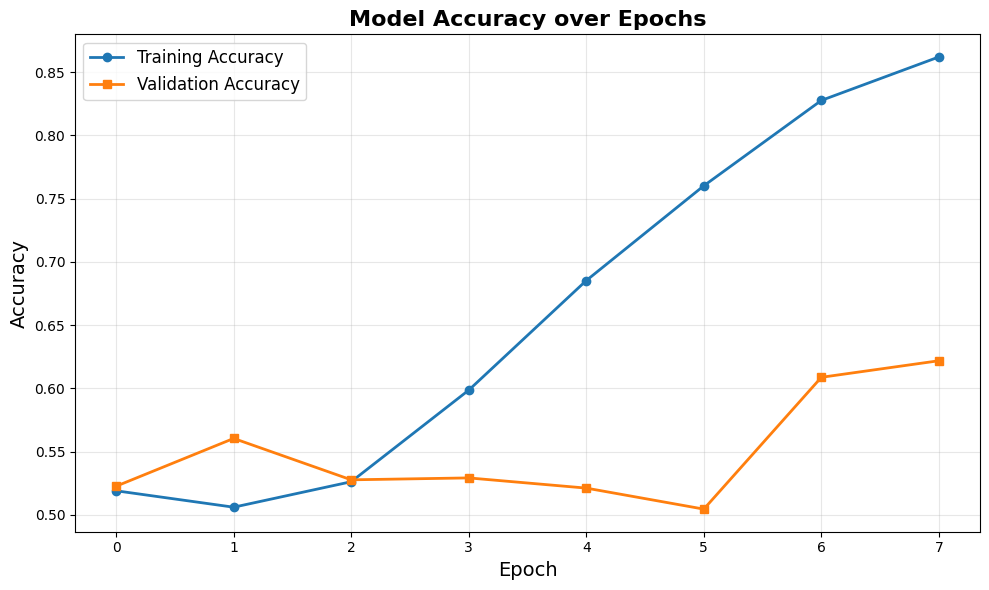

Saved: accuracy.png


In [ ]:
# Visualization 1: Training and Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2, marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2, marker='s')
plt.title('Model Accuracy over Epochs', fontsize=16, fontweight='bold')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('visualizations/accuracy.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: accuracy.png")

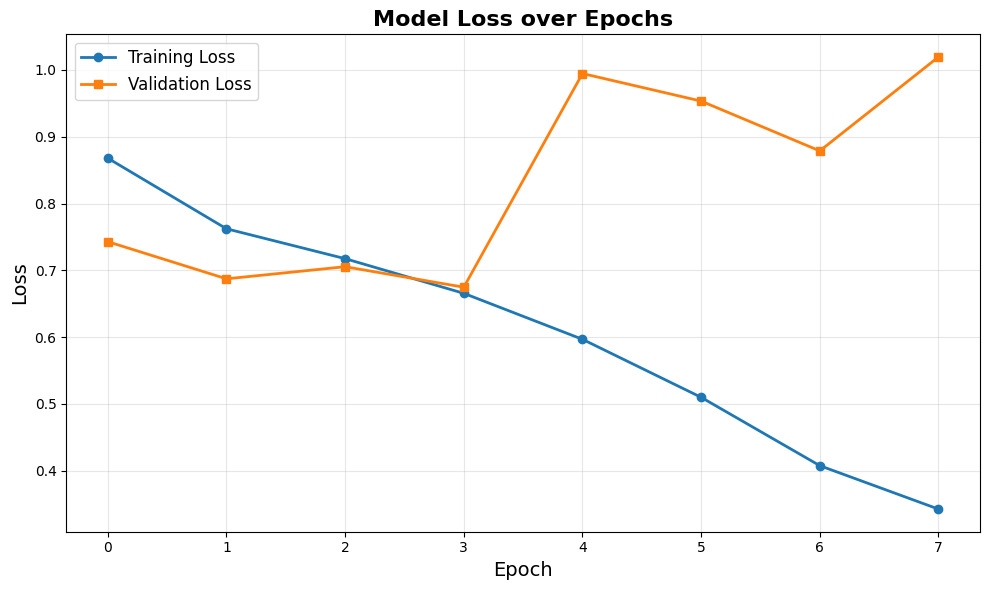

Saved: loss.png


In [ ]:
# Visualization 2: Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', linewidth=2, marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2, marker='s')
plt.title('Model Loss over Epochs', fontsize=16, fontweight='bold')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('visualizations/loss.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: loss.png")

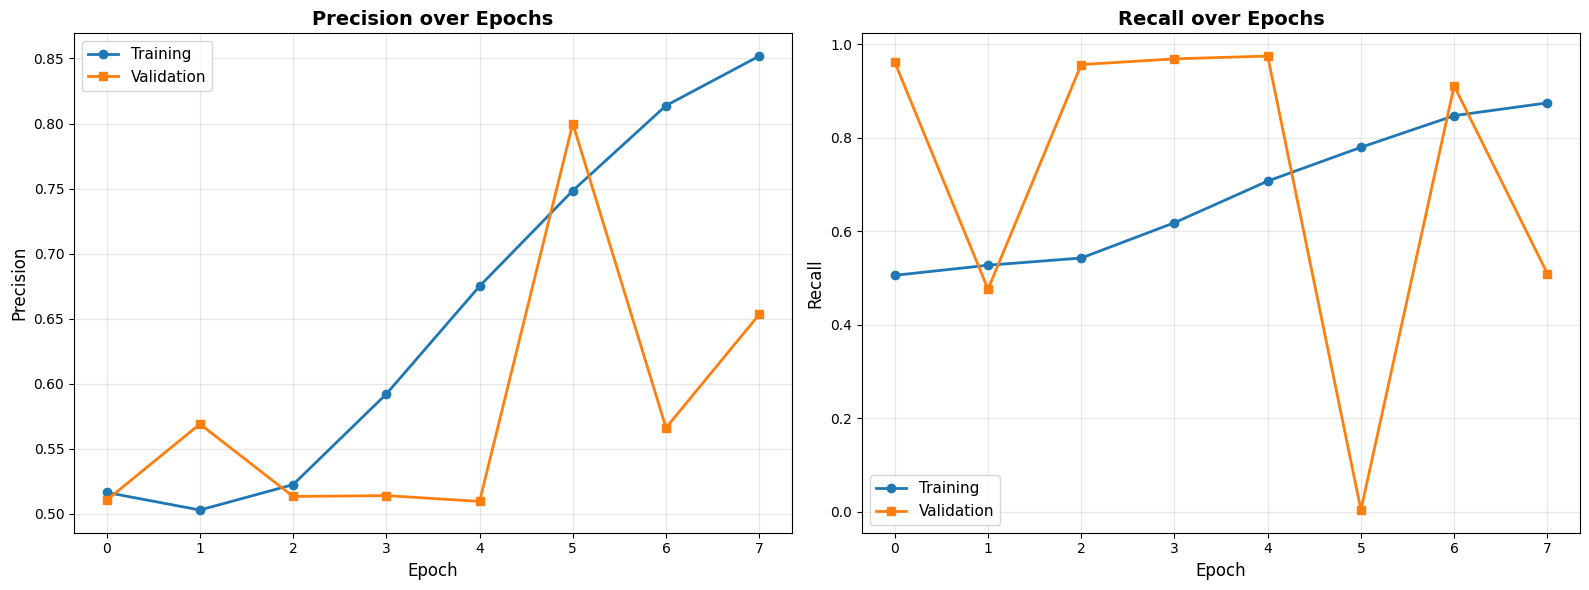

Saved: precision_recall.png


In [ ]:
# Visualization 3: Precision and Recall
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Precision
axes[0].plot(history.history['precision'], label='Training', linewidth=2, marker='o')
axes[0].plot(history.history['val_precision'], label='Validation', linewidth=2, marker='s')
axes[0].set_title('Precision over Epochs', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Precision', fontsize=12)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Recall
axes[1].plot(history.history['recall'], label='Training', linewidth=2, marker='o')
axes[1].plot(history.history['val_recall'], label='Validation', linewidth=2, marker='s')
axes[1].set_title('Recall over Epochs', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Recall', fontsize=12)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('visualizations/precision_recall.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: precision_recall.png")

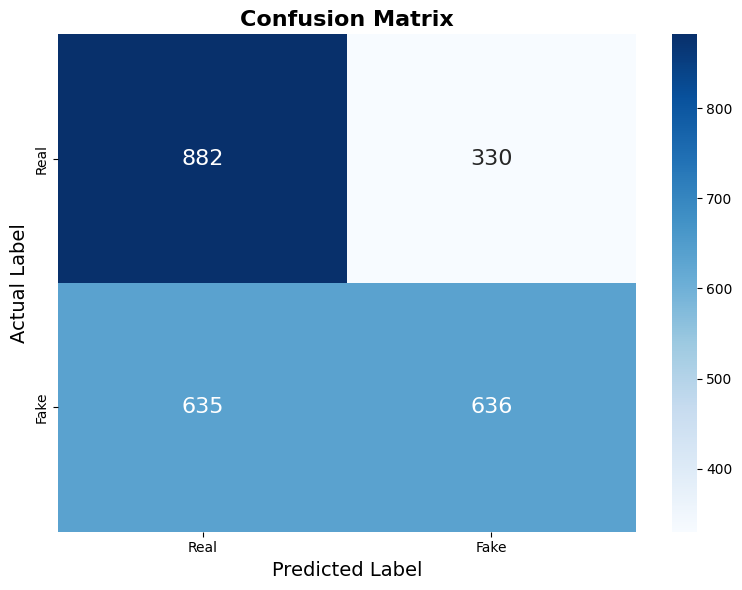

Saved: confusion_matrix.png


In [ ]:
# Visualization 4: Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Real', 'Fake'],
            yticklabels=['Real', 'Fake'],
            annot_kws={'size': 16})
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('Actual Label', fontsize=14)
plt.tight_layout()
plt.savefig('visualizations/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: confusion_matrix.png")

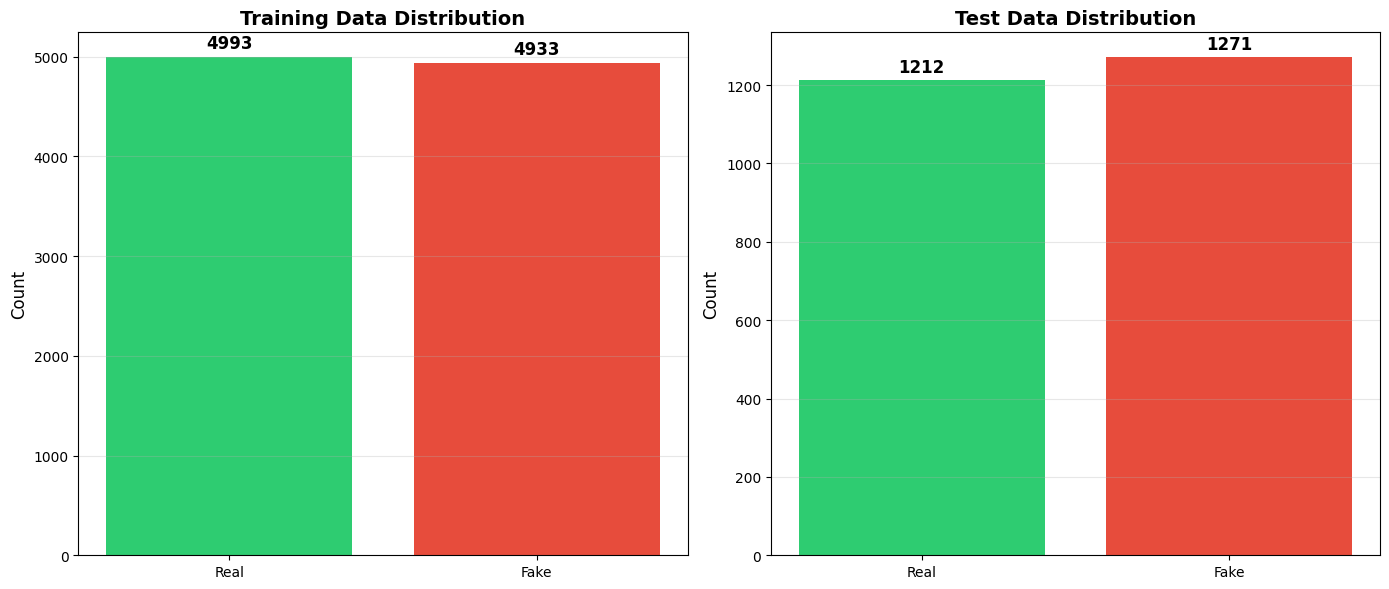

Saved: class_distribution.png


In [ ]:
# Visualization 5: Class Distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Training data
train_counts = train_df['flagged'].value_counts()
axes[0].bar(['Real', 'Fake'], [train_counts[0], train_counts[1]], color=['#2ecc71', '#e74c3c'])
axes[0].set_title('Training Data Distribution', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Count', fontsize=12)
axes[0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate([train_counts[0], train_counts[1]]):
    axes[0].text(i, v + 50, str(v), ha='center', va='bottom', fontweight='bold', fontsize=12)

# Test data
test_counts = test_df['flagged'].value_counts()
axes[1].bar(['Real', 'Fake'], [test_counts[0], test_counts[1]], color=['#2ecc71', '#e74c3c'])
axes[1].set_title('Test Data Distribution', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Count', fontsize=12)
axes[1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate([test_counts[0], test_counts[1]]):
    axes[1].text(i, v + 10, str(v), ha='center', va='bottom', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.savefig('visualizations/class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: class_distribution.png")

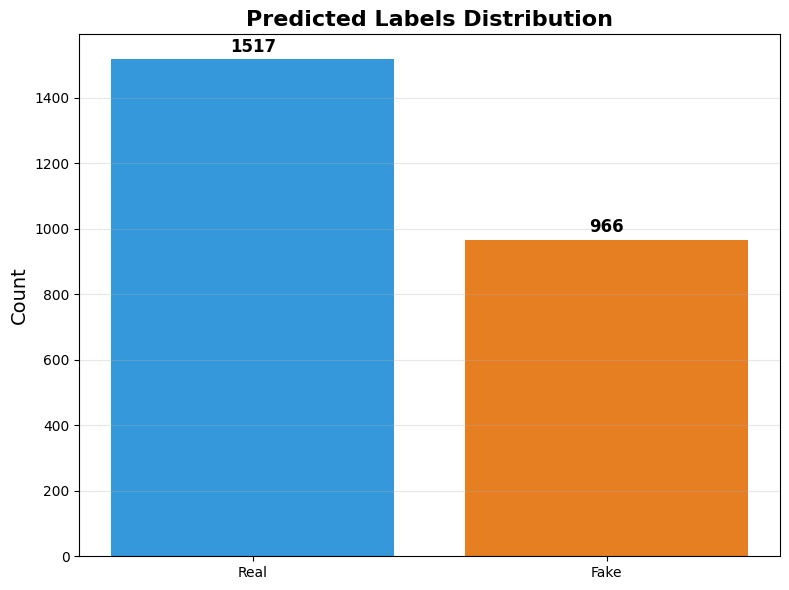

Saved: predictions.png


In [ ]:
# Visualization 6: Prediction Distribution
pred_counts = pd.Series(y_pred).value_counts()
plt.figure(figsize=(8, 6))
plt.bar(['Real', 'Fake'], [pred_counts[0], pred_counts[1]], color=['#3498db', '#e67e22'])
plt.title('Predicted Labels Distribution', fontsize=16, fontweight='bold')
plt.ylabel('Count', fontsize=14)
plt.grid(True, alpha=0.3, axis='y')
for i, v in enumerate([pred_counts[0], pred_counts[1]]):
    plt.text(i, v + 10, str(v), ha='center', va='bottom', fontweight='bold', fontsize=12)
plt.tight_layout()
plt.savefig('visualizations/predictions.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: predictions.png")

## Step 15: Summary

In [ ]:
print("\n" + "="*70)
print("FINAL SUMMARY")
print("="*70)

print("\n Dataset:")
print(f"   Training samples: {len(train_df)}")
print(f"   Validation samples: {len(X_val)}")
print(f"   Test samples: {len(test_df)}")

print("\n  Model Architecture:")
print(f"   Vocabulary size: {vocab_size}")
print(f"   Embedding dimension: {EMBEDDING_DIM}")
print(f"   LSTM units: {LSTM_UNITS}")
print(f"   Dropout rate: {DROPOUT_RATE}")
print(f"   Type: Bidirectional LSTM (2 layers)")

print("\n  Training Configuration:")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Epochs: {len(history.history['loss'])}")
print(f"   Optimizer: Adam (LR: {LEARNING_RATE})")
print(f"   Class weights: Used (balanced)")
print(f"   Learning rate scheduling: Enabled")

print("\n Performance:")
print(f"   Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"   Precision: {precision:.4f} ({precision*100:.2f}%)")
print(f"   Recall:    {recall:.4f} ({recall*100:.2f}%)")
print(f"   F1-Score:  {f1:.4f} ({f1*100:.2f}%)")

print("\n Files Generated:")
print("    lstm_fake_review_model_improved.h5")
print("    predictions_improved.csv")
print("    visualizations/accuracy.png")
print("    visualizations/loss.png")
print("    visualizations/precision_recall.png")
print("    visualizations/confusion_matrix.png")
print("    visualizations/class_distribution.png")
print("    visualizations/predictions.png")

print("\n Key Improvements Applied:")
print("    Class weights for imbalanced data")
print("    Bidirectional LSTM architecture")
print("    Extended training (15 epochs)")
print("    Learning rate scheduling")
print("    Batch normalization")
print("    Multiple evaluation metrics")


FINAL SUMMARY

 Dataset:
   Training samples: 9926
   Validation samples: 1986
   Test samples: 2483

  Model Architecture:
   Vocabulary size: 10000
   Embedding dimension: 128
   LSTM units: 128
   Dropout rate: 0.5
   Type: Bidirectional LSTM (2 layers)

  Training Configuration:
   Batch size: 32
   Epochs: 8
   Optimizer: Adam (LR: 0.001)
   Class weights: Used (balanced)
   Learning rate scheduling: Enabled

 Performance:
   Accuracy:  0.6114 (61.14%)
   Precision: 0.6584 (65.84%)
   Recall:    0.5004 (50.04%)
   F1-Score:  0.5686 (56.86%)

 Files Generated:
    lstm_fake_review_model_improved.h5
    predictions_improved.csv
    visualizations/accuracy.png
    visualizations/loss.png
    visualizations/precision_recall.png
    visualizations/confusion_matrix.png
    visualizations/class_distribution.png
    visualizations/predictions.png

 Key Improvements Applied:
    Class weights for imbalanced data
    Bidirectional LSTM architecture
    Extended training (15 epochs)
    Lea